<a href="https://colab.research.google.com/github/VJatla/ECE_516_2021_CNNs_3D/blob/main/CNN_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Hardware information
!lscpu # CPU info
!free -h --si | awk  '/Mem:/{print $2}' # Memory info
# If you have gpu, you can use `!nvidia-smi` to see its properties

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2200.172
BogoMIPS:            4400.34
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

In [1]:
# Install required libraries
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy


from google.colab.patches import cv2_imshow

# Libraries
import time
import numpy as np
import sklearn as skl
import cv2
from matplotlib import pyplot as plt

# Torch modules
# PyTorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
from torchsummary import summary

from sklearn.metrics import accuracy_score

import pdb
import sys
import os
import mediapy as media
%matplotlib inline

In [2]:
# Making sure that the libraries are loaded from the same directory as the torch. This is important, avoids conflicts.
print(f"Torch        : {torch.__path__}")
print(f"Scikit Learn : {skl.__path__}")
print(f"Numpy        : {np.__path__}")
print(f"OpenCV       : {cv2.__path__}")

Torch        : ['/usr/local/lib/python3.7/dist-packages/torch']
Scikit Learn : ['/usr/local/lib/python3.7/dist-packages/sklearn']
Numpy        : ['/usr/local/lib/python3.7/dist-packages/numpy']
OpenCV       : ['/usr/local/lib/python3.7/dist-packages/cv2']


In [3]:
# Checking GPU access
if not torch.cuda.is_available():
  print("GPU not available")
else:
  print("GPU availability          : ", torch.cuda.is_available(),
      "\nTotal devices on the node : ", torch.cuda.device_count(),
      "\nCurrent selected device   : ", torch.cuda.current_device())

GPU not available


In [4]:
# Download data
! rm -rf ./data
!wget https://github.com/VJatla/ECE_516_2021_CNNs_3D/raw/main/gray_X.npy -P ./data/
!wget https://github.com/VJatla/ECE_516_2021_CNNs_3D/raw/main/gray_y.npy -P ./data/

--2021-10-16 19:47:24--  https://github.com/VJatla/ECE_516_2021_CNNs_3D/raw/main/gray_X.npy
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/VJatla/ECE_516_2021_CNNs_3D/main/gray_X.npy [following]
--2021-10-16 19:47:24--  https://media.githubusercontent.com/media/VJatla/ECE_516_2021_CNNs_3D/main/gray_X.npy
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 474000128 (452M) [application/octet-stream]
Saving to: ‘./data/gray_X.npy’

gray_X.npy          100%[===================>] 452.04M   166MB/s    in 2.7s    

2021-10-16 19:47:33 (166 MB/s) - ‘./data/gray_X.npy’ saved [474000128/4740


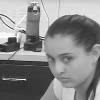


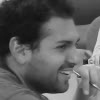

In [5]:
# Loading numpy writing/no-writing numpy arrays and displaying some samples. 
#     Shape      = (158, 300, 100, 100, 1), correspoinding to (Samples, Frames, Height, Width, Channels)
X = np.load("./data/gray_X.npy")
Y = np.load("./data/gray_y.npy")

X_sample_first = X[0]  # First sample
X_sample_last = X[-1]

# First sample
X_sample_first_rgb = np.repeat(X_sample_first, 3, axis=3)
media.show_video(X_sample_first_rgb, height=100, codec='gif', fps=30)

# Last sample
X_sample_last_rgb = np.repeat(X_sample_last, 3, axis=3)
media.show_video(X_sample_last_rgb, height=100, codec='gif', fps=30)

In [ ]:
# Creating training and testing sets
X_train = X[0:120]
X_test = X[120:158]

Y_train = Y[0:120]
Y_test  = Y[120:158]
Y_train = Y_train.reshape(-1,1)
Y_test = Y_test.reshape(-1,1)

In [ ]:
# Reshape to match expectation of pytorch (N, C_in, D_in, H, W)
# Swap axes channels with depth
# NOTE: Reshape fucntion scrambled the image. So I used three swaps to get it 
# to desired shape.
# Training set
X_train = np.swapaxes(X_train, 1, 4) # (N, D_in, H, W, C_in) -> (N, C_in, H, W, D_in)
X_train = np.swapaxes(X_train, 2, 4) # (N, C_in, H, W, D_in) -> (N, C_in, D_in, W, H)
X_train = np.swapaxes(X_train, 3, 4) # (N, C_in, D_in, W, H) -> (N, C_in, D_in, H, W)


X_test = np.swapaxes(X_test, 1, 4) # (N, D_in, H, W, C_in) -> (N, C_in, H, W, D_in)
X_test = np.swapaxes(X_test, 2, 4) # (N, C_in, H, W, D_in) -> (N, C_in, D_in, W, H)
X_test = np.swapaxes(X_test, 3, 4) # (N, C_in, D_in, W, H) -> (N, C_in, D_in, H, W)

# Displaying to make sure the swapping worked
X_train_first_sample = X_train[0,0]  # (D_in, H, W)
X_train_first_sample_gray = np.expand_dims(X_train_first_sample, axis=3) # (D_in, H, W, C_in = 1) == gray
X_train_first_sample_rgb = np.repeat(X_train_first_sample_gray, 3, axis=3) # (D_in, H, W, C_in = 3) == rgb
media.show_video(X_train_first_sample_rgb, height=100, codec='gif', fps=30)

# Displaying to make sure the swapping worked
X_test_last_sample = X_test[-1,0]  # (D_in, H, W)
X_test_last_sample_gray = np.expand_dims(X_test_last_sample, axis=3) # (D_in, H, W, C_in = 1) == gray
X_test_last_sample_rgb = np.repeat(X_test_last_sample_gray, 3, axis=3) # (D_in, H, W, C_in = 3) == rgb
media.show_video(X_test_last_sample_rgb, height=100, codec='gif', fps=30)

In [ ]:
# Loading numpy arrays to torch
X_train_torch = torch.from_numpy(X_train).float()
X_test_torch = torch.from_numpy(X_test).float()

Y_train_torch = torch.from_numpy(Y_train).float()
Y_test_torch = torch.from_numpy(Y_test).float()

In [ ]:
# Creating training and testing loaders
batch_size = 4

# Creating training and testing sets using pytorch DataSet class
train = torch.utils.data.TensorDataset(X_train_torch, Y_train_torch)
test = torch.utils.data.TensorDataset(X_test_torch, Y_test_torch)

# Dataloader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = True)

In [ ]:
# A simple 3D-CNN network
num_classes = 2

# Create CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv_layer1 = self._conv_layer_set(1, 2)
        self.conv_layer2 = self._conv_layer_set(2, 4)
        self.fc1 = nn.Linear(15972, 64)
        self.fc2 = nn.Linear(64, 1) # 1 for binary classification
        self.relu = nn.LeakyReLU()
        self.batch=nn.BatchNorm1d(64)
        self.drop=nn.Dropout(p=0.5)        
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv3d(in_c, out_c, 3, stride=1, padding=1, padding_mode="zeros"),
        nn.LeakyReLU(),
        nn.MaxPool3d((3, 3, 3)),
        )
        return conv_layer
    

    def forward(self, x):
        # Set 1
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.batch(out)
        out = self.drop(out)
        out = self.fc2(out)
        
        return out

#Definition of hyperparameters
num_epochs = 5

# Create CNN
model = CNNModel()
# model.cuda()

# Cross Entropy Loss 
error =  nn.BCEWithLogitsLoss()

# SGD Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [ ]:
# CNN model training
loss_list = []
test_accuracy_list = []
train_accuracy_list = []
stime = time.time()
for epoch in range(num_epochs):
    for i, (train, labels) in enumerate(train_loader):
        
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
            
    
    # Iterate through training dataset
    y_pred = []
    y_true = []
    with torch.no_grad():
      for images, labels in train_loader:

          # Forward propagation
          outputs = model(images)

          # Get predictions

          predicted = torch.round(torch.sigmoid(outputs))

          # Collect prediction and ground truth
          y_pred += predicted.detach().numpy().flatten().tolist()
          y_true += labels.flatten().numpy().tolist()

      train_accuracy = round(accuracy_score(y_true, y_pred), 2)

    
    # Iterate through test dataset
    y_pred = []
    y_true = []
    with torch.no_grad():
      for images, labels in test_loader:

          # Forward propagation
          outputs = model(images)

          # Get predictions
          predicted = torch.round(torch.sigmoid(outputs))

          # Collect prediction and ground truth
          y_pred += predicted.detach().numpy().flatten().tolist()
          y_true += labels.flatten().numpy().tolist()

    test_accuracy = round(accuracy_score(y_true, y_pred), 2)


    # store loss and iteration
    loss_list.append(loss.data)
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)

    print('Epoch: {}  Train Loss: {}  Train Acc.: {} Test Acc.: {}'.format(epoch, loss.data, train_accuracy, test_accuracy))

etime = time.time()
dtime = etime-stime
print(f"For {num_epochs} it took {dtime/60} minutes")

In [ ]:
# visualization loss 
plt.plot(np.arange(0,num_epochs),loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Epochs")
plt.show()

# visualization accuracy 
plt.plot(np.arange(0,num_epochs), train_accuracy_list,color = "red")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.title("CNN: Training Accuracy vs Epochs")
plt.show()

# visualization accuracy 
plt.plot(np.arange(0,num_epochs),test_accuracy_list,color = "red")
plt.xlabel("Epochs")
plt.ylabel("Testing Accuracy")
plt.title("CNN: Testing Accuracy vs Epochs")
plt.show()